In [1]:
import numpy as np
import pandas as pd
from numpy import pi as pi
from scipy import interpolate
from scipy.misc import derivative
import matplotlib.pyplot as plt

In [25]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

# threshold quadratic transfer function
def f(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

def xfer_func(Ialpha):
    return 0.04*(np.power((np.maximum(Ialpha, 0)), 2))

def df(Ialpha):
    return 2*0.04*np.maximum(Ialpha,0)

# Independent noise

In [174]:
def two_ring_model(t0, T, dt, phi, N, tau_E, tau_I, tau_n, c_ne, c_ni, B, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c, a, b):
    # firing rate vectors for ring 1 and ring 2
    r1 = np.zeros((2*N,1))
    r2 = np.zeros((2*N,1))
    r_E1 = np.zeros((N,1))
    r_I1 = np.zeros((N,1))
    r_E2 = np.zeros((N,1))
    r_I2 = np.zeros((N,1))

    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((4*N, 1))
    R_n = np.zeros((4*N, 1))

    xs = np.linspace(0, N-1, N)

    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # Connectivity matrix 
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)

    W_E1E1 = W_E2E2 = J_EE*G_ori
    W_E1I1 = W_E2I2 = J_EI*G_ori
    W_I1E1 = W_I2E2 = J_IE*G_ori
    W_I1I1 = W_I2I2 = J_II*G_ori

    W_E1E2 = b*W_E2E2 # b scales ring2 output connectivity strength wrt within ring2 connectivity strength
    W_E1I2 = b*W_E2I2
    W_I1E2 = b*W_I2E2
    W_I1I2 = b*W_I2I2

    W_E2E1 = a*W_E1E1 # a scales ring1 output connectivity strength wrt within ring1 connectivity strength
    W_E2I1 = a*W_E1I1
    W_I2E1 = a*W_I1E1
    W_I2I1 = a*W_I1I1

    W = np.block([
        [W_E1E1, W_E1I1, W_E1E2, W_E1I2], 
        [W_I1E1, W_I1I1, W_I1E2, W_I1I2], 
        [W_E2E1, W_E2I1, W_E2E2, W_E2I2], 
        [W_I2E1, W_I2I1, W_I2E2, W_I2I2]
    ])
    
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])


    h = np.block([
        [h],
        [h],
        [h],
        [h]
    ])

    r_ss = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    r_n = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    # initial inputs 
    Id = np.full((4*N,1), B) + c*h + (sgn*W)@r_ss
    In = np.full((4*N,1), B) + c*h + (sgn*W)@r_n
    
    
    # smoothed noise process 
    eta = np.zeros((4*N, 1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    for m in range(M):
    # deterministic sim
        r_ss += dt*(1/tau)*(-r_ss + f(k, n, Id))
        Id = np.full((4*N,1), B) + c*h + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(4*N,1)
        eta += (1/tau_n) * (-eta * dt + np.sqrt(2*tau_n*dt)*x)
        r_n += dt*(1/tau)*(-r_n + f(k, n, In + c_n*eta))
        In = np.full((4*N,1), B) + c*h + (sgn*W)@r_n # note: sgn matrix incorporates minus signs for I
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, xs, ts, c, h

In [151]:
def calculate_cov(f, N, r_ss, W, c_ne, c_ni, tau_n):
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])
    
    xs = np.arange(-20000,20000)
    #df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(f(0.04, 2, xs), prepend=0))
    #L = np.diagflat(df(c*h + (sgn*W)@r_ss))
    L = np.diagflat(derivative(f, c*h + (sgn*W)@r_ss, dx=1e-6, n=1))
    
    
    LW = L@W
    Eye = np.eye(4*N)
    
    M = -Eye + LW
    Minv = np.linalg.inv(M)
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    D = c_n@L
    D = np.sqrt(2*tau_n)*D

    Sigma = Minv@D@((Minv@D).T)
    
    return Sigma    

In [359]:
r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                             T=250, 
                                             dt=0.1, 
                                             phi=45, 
                                             N=180, 
                                             tau_E=20, 
                                             tau_I=10, 
                                             tau_n = 1, 
                                             c_ne=1, 
                                             c_ni=1, 
                                                       
                                             B = 0,
                                                       
                                             J_EE=0.044, 
                                             J_II=0.017, 
                                             J_EI=0.020, 
                                             J_IE=0.042, 
                                                       
                                             sigma_ori=32, 
                                             sigma_FF=50, 
                                                       
                                             k=0.04, 
                                             n=2.0, 
                                             c=40,
                                             
                                             a=.02, 
                                             b=.05)

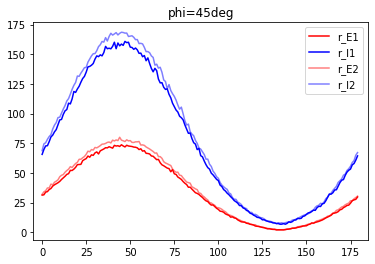

In [360]:
N = 180

plt.plot(r_n[:N], label='r_E1', color='r', alpha=1)
plt.plot(r_n[N:2*N], label='r_I1', color='b', alpha=1)
plt.plot(r_n[2*N:3*N], label='r_E2', color='r', alpha=.5)
plt.plot(r_n[3*N:], label='r_I2', color='b', alpha=.5)
plt.title('phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

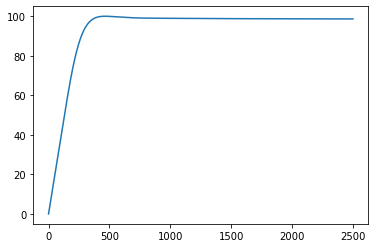

In [371]:
plt.plot(R_ss[550])
plt.show()

## Theory

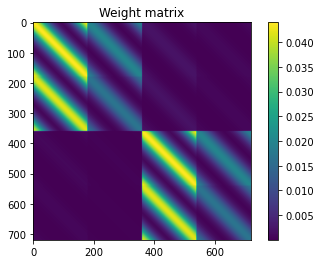

In [362]:
plt.imshow(W)
plt.colorbar()
plt.title('Weight matrix')
plt.show()

In [363]:
Sigma = calculate_cov(f=xfer_func, N=180, r_ss=r_ss, W=W, c_ne=1, c_ni=1, tau_n=1)

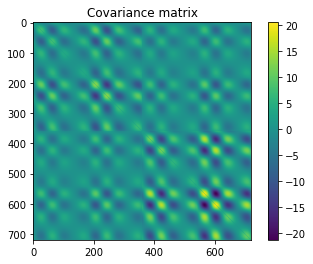

In [365]:
plt.imshow(Sigma - np.diagflat(np.diag(Sigma)))
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

In [366]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

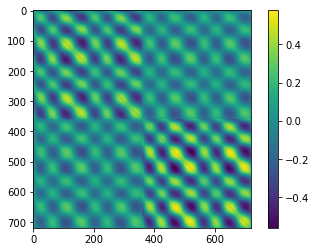

In [367]:
C = correlation_from_covariance(Sigma)

plt.imshow(C-np.diagflat(np.diag(C)))
plt.colorbar()
plt.show()

The next two plots fix a neuron $i(r)$ at $i(r) = 45^\circ$ and 
display $\text{Corr}(i(r), j(r))$ for all $j(r) \neq i(r)$. The argument $r$ is meant to emphasize from which ring neuron $i$ is from; so $r \in \{\text{ring}_1, \text{ring}_2\}.$

For example, the blue curve fixes neuron $i(\text{ring}_1) = 45$, and plots $\text{Corr}(i(\text{ring}_1), j(\text{ring}_1))$ for all $j(\text{ring}_1) \neq i(\text{ring}_1)$; ie, the pairwise correlations between the neuron at 45 degrees in ring 1 with all other neurons in ring 1. Likewise, the orange curve fixes a neuron $i(\text{ring}_2) = 45$, and plots $\text{Corr}(i(\text{ring}_2), j(\text{ring}_2)).$ 

The green curve fixes a neuron $i(\text{ring}_2) = 45$ and plots $\text{Corr}(i(\text{ring}_2), j(\text{ring}_1))$ for all $j(\text{ring}_1) \neq i(\text{ring}_2)$. 

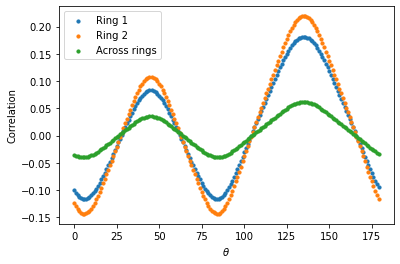

In [368]:
C1_E = C[:N, :N]
C2_E = C[2*N:3*N, 2*N:3*N]
C12_E = C[:N, 2*N:3*N]

y1 = np.delete(C1_E[45,:], [45])
y2 = np.delete(C2_E[45,:], [45])
y12 = np.delete(C12_E[45,:], [45])

xs = np.arange(180)
xs = np.delete(xs, [45])

plt.scatter(xs, y1, s=10, label='Ring 1')
plt.scatter(xs, y2, s=10, label='Ring 2')
plt.scatter(xs, y12, s=10, label='Across rings')

plt.ylabel('Correlation')
plt.xlabel(r'$\theta$')
plt.legend()

plt.show()

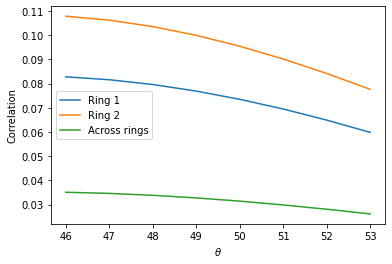

In [369]:
plt.plot(C1_E[45,46:54], label='Ring 1')
plt.plot(C2_E[45,46:54], label='Ring 2')
plt.plot(C12_E[45,46:54], label='Across rings')
labels=np.arange(46,54)
xs=np.arange(0,8)
plt.legend()
plt.ylabel('Correlation')
plt.xlabel(r'$\theta$')
plt.xticks(xs,labels)
plt.show()

## $FI_E$ as a function of connectivity parameter

In [372]:
betas = np.arange(0, 0.1, 0.0025)
alphas = np.arange(0, 0.1,0.0025)
betas = betas[::-1]
alphas = alphas[::-1]

In [374]:
#FI_E1 = np.zeros((len(alphas), len(betas)))
#FI_E2 = np.zeros((len(alphas), len(betas)))
FI_E1 = []
FI_E2 = []
for b in betas:
    print(b)
    r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                             T=250, 
                                             dt=0.1, 
                                             phi=45, 
                                             N=180, 
                                             tau_E=20, 
                                             tau_I=10, 
                                             tau_n = 1, 
                                             c_ne=1, 
                                             c_ni=1, 
                                                       
                                             B = 0,
                                                       
                                             J_EE=0.044, 
                                             J_II=0.017, 
                                             J_EI=0.020, 
                                             J_IE=0.042, 
                                                       
                                             sigma_ori=32, 
                                             sigma_FF=50, 
                                                       
                                             k=0.04, 
                                             n=2.0, 
                                             c=40,
                                             
                                             a=0, 
                                             b=b)
    
    Sigma = calculate_cov(f=xfer_func, N=180, r_ss=r_ss, W=W, c_ne=1, c_ni=1, tau_n=1)
    N = 180
    
    Sigma1_E = Sigma[:N, :N]
    Sigma2_E = Sigma[2*N:3*N, 2*N:3*N]
    
    Sigma1_E_inv = np.linalg.inv(Sigma1_E)
    Sigma2_E_inv = np.linalg.inv(Sigma2_E)
    
    rss_E1 = r_ss[:N]
    rss_E2 = r_ss[2*N:3*N]
    
    G_E1 = np.diff(rss_E1, axis=0, append=rss_E1[0][0])
    G_E2 = np.diff(rss_E2, axis=0, append=rss_E2[0][0])
    
    fi_E1 = ((G_E1.T)@Sigma1_E_inv@G_E1)[0][0]
    fi_E2 = ((G_E2.T)@Sigma2_E_inv@G_E2)[0][0]
    
    FI_E1.append(fi_E1)
    FI_E2.append(fi_E2)

0.0975
0.095
0.0925
0.09
0.08750000000000001
0.085
0.0825
0.08
0.0775
0.075
0.0725
0.07
0.0675
0.065
0.0625
0.06
0.0575
0.055
0.0525
0.05
0.0475
0.045
0.0425
0.04
0.0375
0.035
0.0325
0.03
0.0275
0.025
0.0225
0.02
0.0175
0.015
0.0125
0.01
0.0075
0.005
0.0025
0.0


In [375]:
FI_E1

[52.52075591774097,
 52.933706344889764,
 53.34679257805057,
 53.76000538094847,
 54.173335910041956,
 54.58677543248719,
 55.000315504404675,
 55.4139479161595,
 55.82766467850279,
 56.241458032824205,
 56.65532047385132,
 57.06924462343605,
 57.48322344599687,
 57.89725006562185,
 58.311317864850594,
 58.72542056225158,
 59.1395519457142,
 59.55370616167342,
 59.967877683930844,
 60.382061185348775,
 60.796251709374765,
 61.210444557847865,
 61.62463541619644,
 62.03882030900667,
 62.452995592885856,
 62.8671580679177,
 63.281304826287695,
 63.69543345252722,
 64.1095418230059,
 64.52362828734434,
 64.937691539953,
 65.35173057043437,
 65.76574481221041,
 66.179733861244,
 66.59369760791121,
 67.00763618501892,
 67.42154981597221,
 67.83543874624809,
 68.24930329910401,
 68.66314375057755]

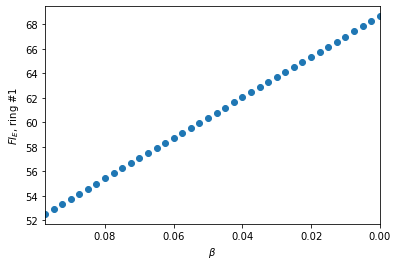

In [376]:
plt.scatter(betas, FI_E1)
plt.xlabel(r'$\beta$')
plt.ylabel('$FI_E$, ring #1')
plt.xlim(max(betas),min(betas))
plt.show()

In [377]:
np.diff(FI_E1)

array([0.41295043, 0.41308623, 0.4132128 , 0.41333053, 0.41343952,
       0.41354007, 0.41363241, 0.41371676, 0.41379335, 0.41386244,
       0.41392415, 0.41397882, 0.41402662, 0.4140678 , 0.4141027 ,
       0.41413138, 0.41415422, 0.41417152, 0.4141835 , 0.41419052,
       0.41419285, 0.41419086, 0.41418489, 0.41417528, 0.41416248,
       0.41414676, 0.41412863, 0.41410837, 0.41408646, 0.41406325,
       0.41403903, 0.41401424, 0.41398905, 0.41396375, 0.41393858,
       0.41391363, 0.41388893, 0.41386455, 0.41384045])